In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
from models.model_fpgan import FPGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [59]:
data = pd.read_csv("D:/Datasets/cardiovascular/cardio.csv",sep=";")
data = data.drop(columns=['id'])
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [60]:
data.shape

(70000, 12)

In [61]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())

In [62]:
target = 'cardio'

In [63]:
X = data.drop(columns=[target])
y = data[target]

In [64]:
model_ctgan = FPGANSynthesizer(epochs=20, verbose=True)
original_losses, tranformed_privacies, losses = model_ctgan.fit(data)

Epoch 1, Loss G: -0.1548,Loss D: -0.9838
Epoch 2, Loss G: -0.2429,Loss D: -0.7019
Epoch 3, Loss G: -0.2347,Loss D: -0.3582
Epoch 4, Loss G: -0.0416,Loss D: -0.9109
Epoch 5, Loss G: -0.0135,Loss D: -0.5938
Epoch 6, Loss G: -0.0030,Loss D: -0.7675
Epoch 7, Loss G: -0.0713,Loss D: -0.1441
Epoch 8, Loss G: -0.0712,Loss D: -0.3219
Epoch 9, Loss G: -0.0518,Loss D: -0.3769
Epoch 10, Loss G: -0.0771,Loss D: -0.4337
Epoch 11, Loss G: -0.0955,Loss D:  0.2133
Epoch 12, Loss G: -0.0513,Loss D:  0.2104
Epoch 13, Loss G: -0.1453,Loss D: -0.2701
Epoch 14, Loss G: -0.0294,Loss D: -0.2052
Epoch 15, Loss G: -0.1051,Loss D: -0.6303
Epoch 16, Loss G: -0.1601,Loss D:  0.1778
Epoch 17, Loss G: -0.0339,Loss D:  0.0765
Epoch 18, Loss G: -0.0991,Loss D: -0.0605
Epoch 19, Loss G: -0.1128,Loss D: -0.1167
Epoch 20, Loss G: -0.1914,Loss D: -0.3097


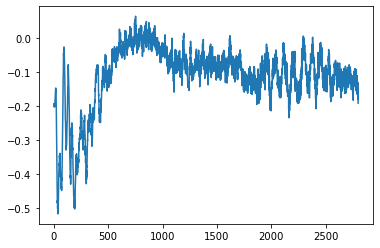

In [65]:
plt.plot(losses)
plt.show()

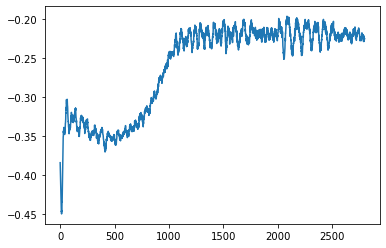

In [66]:
plt.plot(tranformed_privacies)
plt.show()

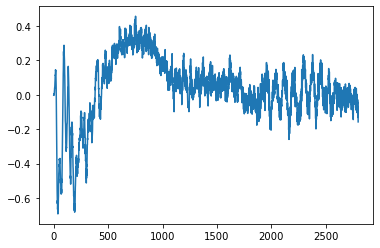

In [67]:
plt.plot(original_losses)
plt.show()

In [68]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [69]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame
samples = samples[:2000]
data = data[:2000]

In [70]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.03083883]


## Fidelity

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test)

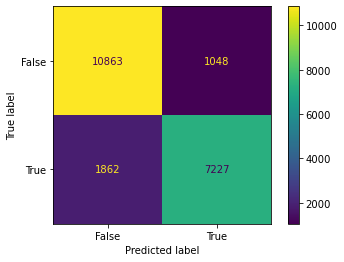

In [72]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [73]:
percentage, same_pred, dif_pred = eval_fidelity(rr_pred, fr_pred)

In [74]:
print(same_pred, dif_pred)

18090 2910


## Final plot

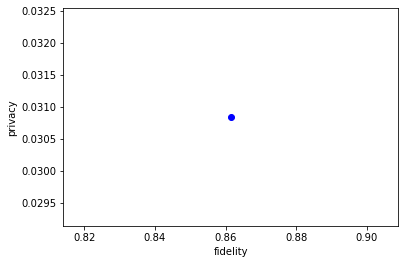

In [75]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()